# Aprendizado por refor√ßo

- O que vamos aprender?

A utilizar o algoritmo de Q-Learning para treinar um agente, nesse caso o ambiente vai ser o [Frozen-Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

- Resultado esperado?

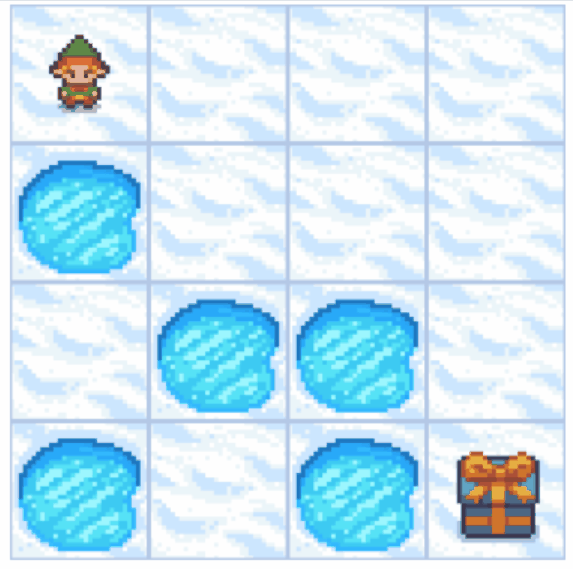

- Tem exerc√≠cios?

Sim, no final!

## Refer√™ncias

- [Pratical AI with Python and Reinforcement Learning](https://www.udemy.com/course/practical-ai-with-python-and-reinforcement-learning)
- [Deep RL Course](https://huggingface.co/learn/deep-rl-course)
- [Prof. MURAKAMI - MATEM√ÅTICA RAPIDOLA](https://www.youtube.com/@Murakami.)

## Bibliotecas

- [Gymnasium](https://gymnasium.farama.org/)
- [Matplotlib](https://matplotlib.org/)

## Autor desse Notebook

- Guilherme Alves Silveira

## Q-Learning [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

In [ ]:
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install ipympl > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11

!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari,accept-rom-license]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [5]:
import time
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from gymnasium import logger as gymlogger
from gymnasium.wrappers.record_video import RecordVideo
from gymnasium.utils import play
from IPython.display import HTML
from IPython import display as ipythondisplay
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

gymlogger.set_level(40) # error only
%matplotlib inline

C:\Users\Guilherme Alves\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [6]:
from IPython.display import clear_output

def show_environment(array):
    plt.axis("off")
    plt.imshow(environment)
    plt.show()

## Apenas testando a√ß√µes aleat√≥rias para "sentir" o ambiente

### Espa√ßo de A√ß√£o

O formato da a√ß√£o √© (1,) no intervalo {0, 3}, indicando para qual dire√ß√£o mover o jogador.

- 0: Mover para a esquerda
- 1: Mover para baixo
- 2: Mover para a direita
- 3: Mover para cima

### Espa√ßo de Observa√ß√£o

A observa√ß√£o √© um valor que representa a posi√ß√£o atual do jogador como linha_atual * nlinhas + coluna_atual (onde tanto a linha quanto a coluna come√ßam em 0).

Por exemplo, a posi√ß√£o objetivo no mapa 4x4 pode ser calculada da seguinte forma: 3 * 4 + 3 = 15. O n√∫mero de observa√ß√µes poss√≠veis depende do tamanho do mapa.

A observa√ß√£o √© retornada como um int().

Refer√™ncia:

[Frozen Lake - Gymnasium](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

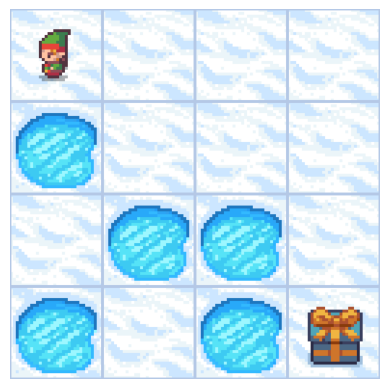

In [7]:
env_name = "FrozenLake-v1"
env = gym.make(env_name, render_mode="rgb_array", 
               desc=generate_random_map(size=4), 
               is_slippery=False)
env.reset()

for step in range(30):
    environment = env.render()
    show_environment(environment)
    action = env.action_space.sample()
    obs, reward, term, trunc, info = env.step(action)
    time.sleep(0.2)

    clear_output(wait=True)
    if term or trunc:
        env.reset()
        break

env.close()

## Execu√ß√£o manual do jogo

Obs.: Se n√£o funcionar, tenta rodar o notebook com `python -m notebook` ou utilizar o anaconda

In [8]:
def walk():
    """
    Fun√ß√£o para obter a entrada do teclado para caminhar.
    """
    key = input()
    if 'a' == key:
        action = 0
    elif 's' == key:
        action = 1
    elif 'd' == key:
        action = 2
    elif 'w' == key:
        action = 3
    elif 'q' == key:
        print("Saindo do jogo!")
        raise StopIteration()

    return action

In [ ]:
env.reset()

try:
    for step in range(30):
        environment = env.render()
        show_environment(environment)
        action = walk()
        _, _, term, trunc, _ = env.step(action)
        clear_output(wait=True)
except StopIteration as stop:
    pass
env.close()

(0, {'prob': 1})

## Implementa√ß√£o da Q-Table para o algoritmo Q-Learning

- O `state` (estado) √© a representa√ß√£o completa do ambiente; `observation` (observa√ß√£o) √©, normalmente, uma informa√ß√£o parcial do estado. Na biblioteca Gym, os dois termos s√£o usados de forma intercambi√°vel.

Resumindo, no c√≥digo selecionamos ``state` para ficar semelhante a formula matem√°tica do Q-Learning

In [10]:
state_size = env.observation_space.n
action_size = env.action_space.n
# rows-states
q_table = np.zeros([state_size, action_size])
q_table.shape

(16, 4)

- **√âpocas (Epochs)**: Quantas vezes o agente joga o jogo.
- **Alpha**: Taxa de aprendizado ‚Äì muito baixa, o agente pode ser lento para treinar; muito alta, ele ultrapassa a fun√ß√£o de aprendizado.
- **Gamma**: Fator de desconto ‚Äì preferimos receber a recompensa agora em vez de no futuro.
- **Taxa de Decaimento (Decay Rate)**: A velocidade com que atualizamos o √©psilon para aumentar a explora√ß√£o ao longo do tempo; no in√≠cio, exploramos bastante.
- **√âpsilon**: Conceito do ‚Äúbandido de m√∫ltiplos bra√ßos‚Äù (Epsilon-Greedy) ‚Äì equil√≠brio entre Explora√ß√£o e Aproveitamento.

In [11]:
EPOCHS = 20_000
ALPHA = 0.8
GAMMA = 0.95
DECAY_RATE = 0.001
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01 

Na Q-Table abaixo para o Frozen Lake, cada estado possui quatro a√ß√µes poss√≠veis; assim, em uma matriz 4√ó4 teremos 64 fun√ß√µes Q(s, a).
Obs.: O argmax retorna a posi√ß√£o do do maior valor do vetor/matriz.

Exemplo:

$
\begin{matrix}
\text{a√ß√£o esquerda} & \text{a√ß√£o baixo} & \text{a√ß√£o direita} & \text{a√ß√£o cima} \\
0{,}4 & 0 & 0{,}1 & 0 \\
0{,}05 & 0{,}2 & 0{,}5 & 0{,}1 \\
..  & ..  & ..  & ..  \\
0{,}01 & 0{,}9 & 0 & 0 \\
0{,}09 & 0 & 0{,}5 & 0 \\
\end{matrix}
$

$\text{a√ß√£o esquerda} = \mathrm{argmax}\begin{pmatrix} 0{,}4 & 0 & 0{,}1 & 0 \end{pmatrix}$

$\text{a√ß√£o esquerda} = 0$

$\text{a√ß√£o cima} = \mathrm{argmax}\begin{pmatrix} 0{,}05 & 0{,}2 & 0{,}09 & 0{,}7 \end{pmatrix}$

$\text{a√ß√£o cima} = 3$

$\text{a√ß√£o baixo} = \mathrm{argmax}\begin{pmatrix} 0{,}01 & 0{,}9 & 0 & 0 \end{pmatrix}$

$\text{a√ß√£o baixo} = 1$

$\text{a√ß√£o direita} = \mathrm{argmax}\begin{pmatrix} 0{,}09 & 0 & 0{,}5 & 0 \end{pmatrix}$

$\text{a√ß√£o direita} = 2$

In [13]:
print("Inicia com o estado zerado")
print(q_table)
print("Formato do q_table, aonde como explicado acima, possuimos 64 posi√ß√µes, aonde cada posi√ß√£o representa um q-value")
print(q_table.shape)

Inicia com o estado zerado
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Formato do q_table, aonde como explicado acima, possuimos 64 posi√ß√µes, aonde cada posi√ß√£o representa um q-value
(16, 4)


In [ ]:
def epsilon_greedy_action_selection(env, epsilon, q_table, discrete_state):
    """
    Exploitation no ingl√™s √© o mesmo que, ao encontrar um alta retorno, voc√™ tira o m√°ximo de proveito disso.
    Exploration no ingl√™s √© explocar novas possibilidades, como por exemplo, andar por um local para descobrir novas √°reas.
    Exemplo:
        epsilon = 0.1 (10% de chance de explorar)
        random_number = 0.85 (85%)
        ‚Üí 0.85 > 0.1? SIM ‚Üí Exploitation (melhor a√ß√£o do Q-table)

        random_number = 0.05 (5%)
        ‚Üí 0.05 > 0.1? N√ÉO ‚Üí Exploration (a√ß√£o aleat√≥ria)
    """
    random_number = np.random.random()
    if random_number > epsilon: # Isso √© Exploitation
        state_row = q_table[discrete_state,:]
        action = np.argmax(state_row)
    else: # Isso √© Exploration (seleciona uma a√ß√£o aleat√≥ria)
        action = env.action_space.sample()
    return action

Equa√ß√£o Q-Learning:

$Q(s, a) = Q(s, a) + \alpha[R(s, a) + \gamma maxQ(s', a') - Q(s, a)]$

- O $Q(s, a)$ representa o `q_table` acima, aonde o $s$ √© o state, e o $a$ √© o action.
    - Representado pela vari√°vel `old_q_value`.
- $\alpha$ regula o quanto vamos atualizar o q-value, quanto maior, mais r√°pido vamos atualizar esse q-table, por√©m, pode deixar o treino mais inst√°vel.
    - Representado pela constante `ALPHA`.
- $R(s, a)$ recompensa j√° ganha quando a a√ß√£o $Q(s, a)$ foi tomada.
    - Representado pela vari√°vel `reward`.
- $\gamma$ √© o fator de desconto, ou seja, n√£o deixar que o m√°ximo valor influ√™ncie muito a atualiza√ß√£o do estado atual, e de maneira heuristica, permite que se consiga recompensas agora, pois, se toda recompensa √© alta, o algoritmo n√£o consegue avan√ßar.
    - Representado pela constante `GAMMA`.
    - Sendo o $\gamma = 0.99$, valoriza recompensas futuras
    - Sendo o $\gamma = 0.01$, valoriza recompensas imediatas
- $max Q(s', a')$ √© a maxima recompensa do pr√≥ximo estado, √© uma forma de atualizar o $Q(s, a)$ sabendo que na frente se tem recompensa (lembrar da brincadeira de frio-quente).
    - Representado pela vari√°vel `next_optimal_q_value`.
- O $max Q(s', a') - Q(s, a)$, representa a diferen√ßa temporal entre o valor atual menos o novo valor aprendido, no caso, seria o erro de predi√ß√£o (lembra um pouco o conceito de redu√ß√£o dos minimos quadrados).
    - Representados pelo seguinte c√≥digo: `next_optimal_q_value - old_q_value`.

Videos sobre Q-Learning:

- [[AULA] Aprendizagem por Refor√ßo e o Algoritmo Q-Learning](https://www.youtube.com/watch?v=tz8phEIqKAM)
- [Visualiza√ß√£o do Q-Learning](https://www.youtube.com/watch?v=0xt3MstYo4c)
- [Q-learning - Explained!](https://www.youtube.com/watch?v=TiAXhVAZQl8)

Caso queira ver um exemplo de minimos quadrados passo a passo, veja os links abaixo:

- [M√âTODO DOS M√çNIMOS QUADRADOS ‚úÖ INTRODU√á√ÉO √Ä ESTAT√çSTICA EP 1](https://www.youtube.com/watch?v=9LB9zMIVsmg)
- [M√âTODO DOS M√çNIMOS QUADRADOS ‚úÖ INTRODU√á√ÉO √Ä ESTAT√çSTICA EP 2](https://www.youtube.com/watch?v=iVPt3_5yqqM)
- [M√âTODO DOS M√çNIMOS QUADRADOS ‚úÖ INTRODU√á√ÉO √Ä ESTAT√çSTICA EP 3](https://www.youtube.com/watch?v=005DJw4wa6I)
- [M√âTODO DOS M√çNIMOS QUADRADOS ‚úÖ INTRODU√á√ÉO √Ä ESTAT√çSTICA EP 4](https://www.youtube.com/watch?v=OBYwge51Tt4)

In [15]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    # Q(s, a) <- Q(s, a) + alpha[R(s, a) + gamma maxQ(s', a') - Q(s, a)]
    return old_q_value + ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

Equa√ß√£o de taxa de decaimento:

$min_\epsilon + (max_\epsilon-min_\epsilon) * e^{-decay*epoch}$

A equa√ß√£o acima √© uma das op√ß√µes. Outra forma mais simples de implementar, √© reduzir o valor por algum valor fixo, como $0.00001$ ou $0.00005$, por√©m, voc√™ ter√° que ajustar esse valor de acordo com o n√∫mero de √©pocas (`EPOCHS`).
A de cima j√° leva em considera√ß√£o o n√∫mero de √©pocas.
Resumindo o reduce_epsilon, ao longo do tempo, como o agente vai aprendendo mais sobre o ambiente, n√£o se faz necess√°rio explorar tanto, ent√£o vamos reduzindo aos poucos a explora√ß√£o (exploration) e aumentando a exploita√ß√£o (exploitation). 
Segue passo a passo a fase de treino do agente ü§ñ:
- ü§ñ -> N√£o conhe√ßo nada sobre o ambiente, ent√£o vou explorar ele (epsilon = 0.9).
- ü§ñ -> J√° estou entendendo melhor o ambiente, ent√£o exploro menos, mas as vezes vejo novas possibilidades (epsilon = 0.5).
- ü§ñ -> J√° entendo o suficiente, bem de vez em quando, vejo algumas novas op√ß√µes (epsilon = 0.1).
- Obs.: Lembre se do c√≥digo que cont√©m `random_number > epsilon` ent√£o `exploitation` se n√£o `exploration`
- O `min_epsilon` √© para que n√£o se chegue a `0`.

In [16]:
def reduce_epsilon(epoch):
    return min_epsilon + (max_epsilon-min_epsilon) * np.exp(-DECAY_RATE*epoch)

Explica√ß√£o da fun√ß√£o valor-Q m√°xima (max Q-Value):

$
maxQ(s', a') = maxQ(s_{t+1}, a_{t+1})
$

O `t+1` representa a pr√≥xima posi√ß√£o em rela√ß√£o a posi√ß√£o atual `t`

Rewards (Wins): 0
Rewards (Wins): 271
Rewards (Wins): 980
Rewards (Wins): 1857
Rewards (Wins): 2795
Rewards (Wins): 3768
Rewards (Wins): 4754
Rewards (Wins): 5744
Rewards (Wins): 6731
Rewards (Wins): 7720
Rewards (Wins): 8708
Rewards (Wins): 9697
Rewards (Wins): 10687
Rewards (Wins): 11675
Rewards (Wins): 12666
Rewards (Wins): 13657
Rewards (Wins): 14643
Rewards (Wins): 15630
Rewards (Wins): 16622
Rewards (Wins): 17611


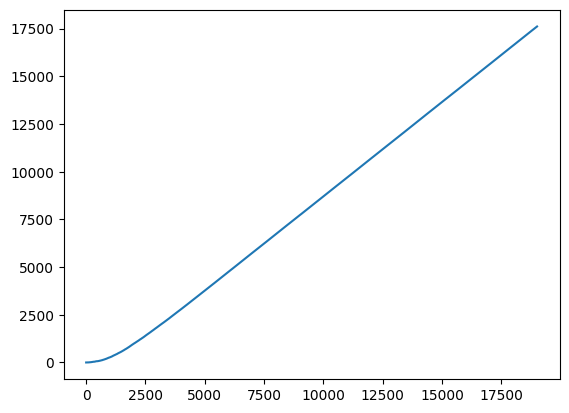

In [17]:
rewards = []
log_interval = 1000

##############################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
epoch_plot_tracker = []
total_reward_plot_tracker = []
##############################

# Agents play the game
for epoch in range(EPOCHS):
    state, info = env.reset()

    done = False
    total_rewards = 0

    while not done:
        # A√ß√£o
        action = epsilon_greedy_action_selection(env, epsilon, q_table, state)
        
        new_state, reward, term, trunc, info = env.step(action)
        
        # Old (atual) Q-Value
        old_q_value = q_table[state, action]

        # Pega o √≥timo pr√≥ximo Q-Value -> max Q(s', a') 
        next_optimal_q_value = np.max(q_table[new_state,:])
        
        # Calcula Q-Value "equilibrado" que podemos usar para atualizar o Q-Value
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        
        # Atualiza a tabela, lembre-se: Q(s, a) = Q(s, a) + alpha(R(s, a) + max Q(s', a') - Q(s, a))
        q_table[state, action] = next_q_value

        # Soma as recompensas para colocar no gr√°fico
        total_rewards += reward
        
        # Agora avan√ßamos para o pr√≥ximo estado, pode associar como se estivesse andando no mapa, nese caso o boneco navega pelo cen√°rio
        state = new_state

        # Se o boneco caiu no gelo por exemplo, ou se chegou ao ba√∫ o done vai ser True.
        done = term or trunc

    epsilon = reduce_epsilon(epoch)
    # O agente terminou essa rodada de jogo, ou seja, toda vez que o done √© True, ent√£o chegou no "Fim de Jogo" ou "Zerou" por exemplo.
    rewards.append(total_rewards)

    # Usado para cada jogo, ir mostrando o aumento da recompensa ao longo do tempo, o y no gr√°fico
    total_reward_plot_tracker.append(np.sum(rewards))
    # A √©poca que teve essa recompensa, o x no gr√°fico
    epoch_plot_tracker.append(epoch)

    ##############################
    if epoch % log_interval == 0:
        print("Rewards (Wins):", int(np.sum(rewards)))
        ax.clear()
        ax.plot(epoch_plot_tracker, total_reward_plot_tracker)
        fig.canvas.draw()
    ##############################

env.close()

In [19]:
# Como se pode ver, o q_table est√° preenchido abaixo, de maneira heuristica, a fun√ß√£o √≥tima (ou pr√≥xima disso) foi registrada na tabela
%matplotlib inline
q_table

array([[0.73509189, 0.        , 0.77378094, 0.73509189],
       [0.73509189, 0.81450625, 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.857375  , 0.81450625],
       [0.81450625, 0.9025    , 0.857375  , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.        , 0.9025    , 0.81450625],
       [0.857375  , 0.95      , 0.9025    , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.95      , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

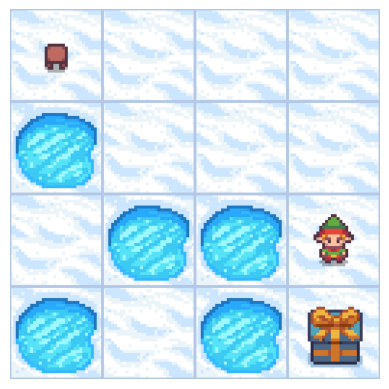

In [21]:
state, info = env.reset()
for steps in range(50):
    environment = env.render()
    show_environment(environment)
    # Seleciona a melhor op√ß√£o nesse caso, pois n√£o estamos treinando o algoritmo
    action = np.argmax(q_table[state,:])
    state, reward, term, trunc, info = env.step(action)
    time.sleep(0.2)
    clear_output(wait=True)

    if term or trunc:
        break

env.close()

# Exerc√≠cios

- Crie uma classe ou m√©todo de treino do agente
- Agora fa√ßa o mesmo para infer√™ncia
- Agora implemente a solu√ß√£o para o ambiente [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/)